In [1]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from app.utils.dataset import DepthDataset, create_data_loader
from models.UNetResNetDepth import UNetResNetDepth
from models.train_depth_model import train_model
from app.utils.env import Env
import matplotlib.pyplot as plt


In [2]:
env = Env()

image_size = 256
transform = transforms.Compose([
    transforms.Resize((256, 848)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 848)),
    transforms.ToTensor()
])



In [3]:
train_dataset = DepthDataset(
    root_dir=env.dataset_path / "train",
    transform=transform,
    target_transform=target_transform,
)
val_dataset = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transform,
    target_transform=target_transform,
)


In [ ]:
from models.UNetAlikeCNN import UNetAlikeCNN

model = UNetAlikeCNN()
train_loader = create_data_loader(train_dataset, batch_size=16)
val_loader = create_data_loader(val_dataset, batch_size=16, shuffle=False)

train_model(model, train_loader, val_loader, num_epochs=30)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# perform examplary inference
raw_image, depth_gt = train_dataset[0]  # raw_image and depth_gt are both tensors
raw_image = raw_image.unsqueeze(0).to(device)  # [1, 3, H, W]
depth_gt = depth_gt.squeeze().numpy()  # [H, W]

In [7]:
model.eval()
with torch.no_grad():
    prediction = model(raw_image)  # [1, 1, H, W]
    prediction = prediction.squeeze().cpu().numpy()  # [H, W]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


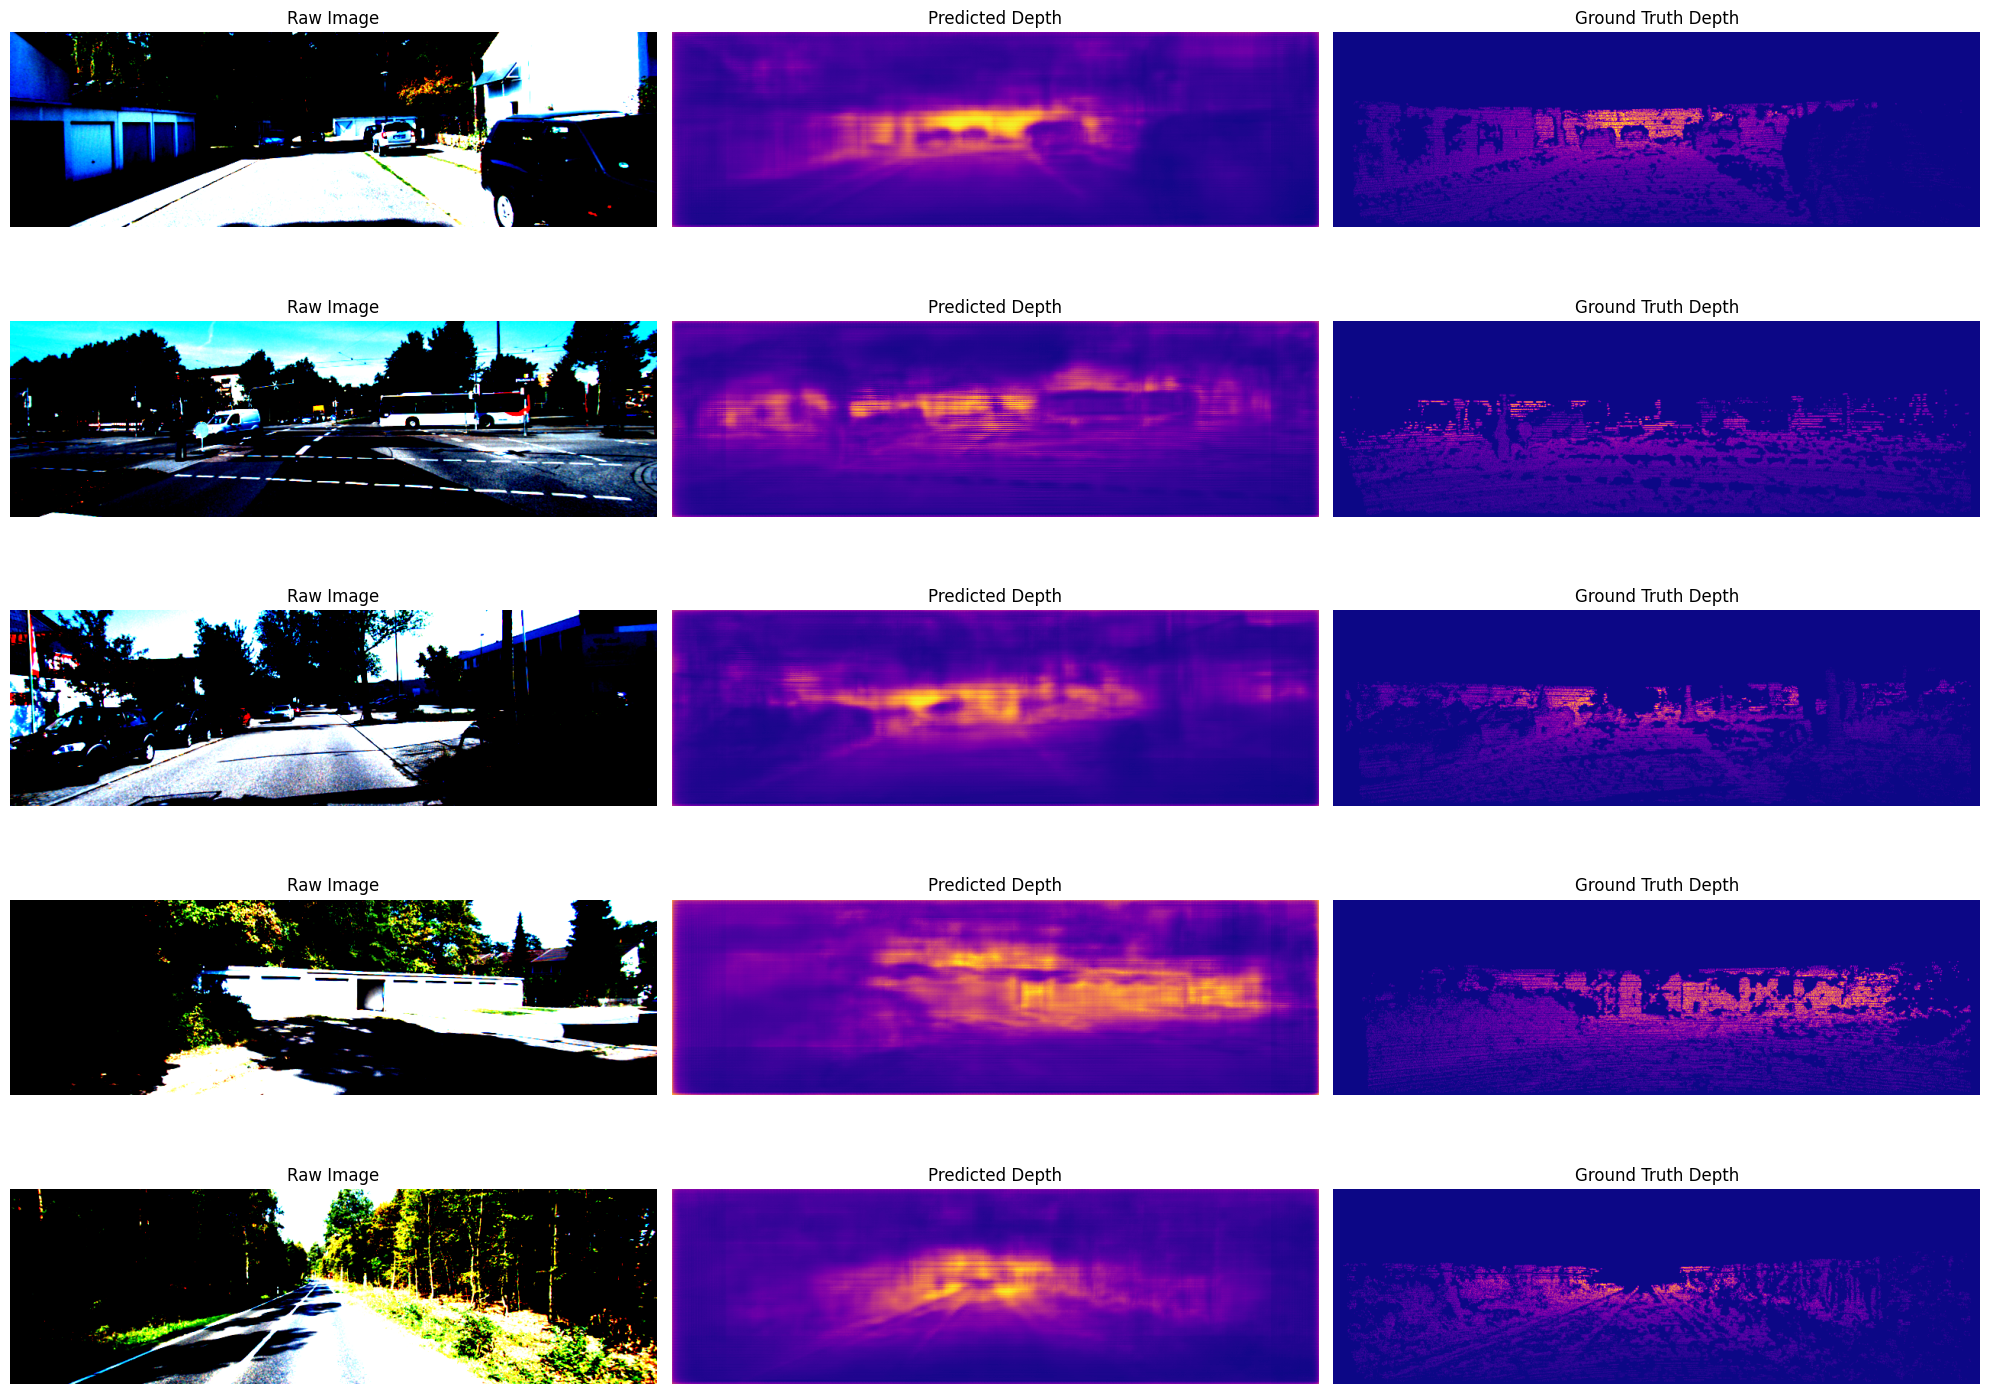

In [8]:
import random

random.seed(23)

num_examples = 5
fig = plt.figure(figsize=(20, 3 * num_examples))

for i in range(num_examples):
    idx = random.randint(0, len(train_dataset) - 1)
    raw_image, depth_image = train_dataset[idx]
    raw_image = raw_image.unsqueeze(0).to(device)  # [1, 3, H, W]
    with torch.no_grad():
        prediction = model(raw_image)
        prediction = prediction.squeeze().cpu().numpy()

    ax = fig.add_subplot(num_examples, 3, i * 3 + 1)
    ax.imshow(raw_image.squeeze().permute(1, 2, 0).cpu(), cmap='plasma')
    ax.set_title("Raw Image")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i * 3 + 2)
    ax.imshow(prediction, cmap='plasma')
    ax.set_title("Predicted Depth")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i * 3 + 3)
    ax.imshow(depth_image.permute(1, 2, 0).numpy() * 255, cmap='plasma')
    ax.set_title("Ground Truth Depth")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
dummy_input = torch.randn(1, 3, 256, 848, requires_grad=True)
torch.onnx.export(model, dummy_input, "model_1.onnx")